# This code implements segmentation of of cysts from OCT images using the variants of U-net, wUnet and Unet++

## This code implements multi-class classification
## This model is adapted from the original codebase in https://github.com/HZCTony/U-net-with-multiple-classification

In [1]:
import os
# The path below should point to the directory containing this notebook and the associated utility files
# Change it if necessary
os.getcwd()
!dir

 Volume in drive C is Windows
 Volume Serial Number is E265-327E

 Directory of C:\Users\Sohini Roy\Documents\Unet_Project\Paper-work\code

12/02/2021  03:57 PM    <DIR>          .
12/02/2021  03:57 PM    <DIR>          ..
12/02/2021  03:27 PM    <DIR>          .ipynb_checkpoints
12/02/2021  03:55 PM    <DIR>          covid-19-rad
10/10/2021  09:49 PM            83,901 Data_pipeline_Medical_data.ipynb
12/02/2021  03:52 PM            12,171 model_new.py
10/11/2021  10:26 AM           110,082 Unet_plus_binary-Baseline_Lung_med.ipynb
12/02/2021  03:57 PM            28,144 Unet_plus_binary_volume_segmentation.ipynb
12/02/2021  02:17 PM         2,202,443 Visualization_covid-19.ipynb
12/02/2021  02:57 PM         2,839,179 Volume_scan_visualization.ipynb
12/02/2021  03:53 PM    <DIR>          __pycache__
               6 File(s)      5,275,920 bytes
               5 Dir(s)  855,997,603,840 bytes free


# A. Lets start by stepwise defining all libraries and functions needed to generate the model and pre-process the data

In [2]:
#Step 1: Load libraries for the U-net Model
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
#from tensorflow import keras
import tensorflow as tf

In [3]:
#Step 2: Import the U-net model
from model_new import *
img_size=(256,256)

In [4]:
n_class=2


In [5]:
#mod = wU_Net(img_size[0],img_size[1],1)
mod = Nest_Net(img_size[0],img_size[1],1,1,deep_supervision=True)

In [6]:
mod.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv11_1 (Conv2D)               (None, 256, 256, 32) 320         main_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv11_1[0][0]                   
__________________________________________________________________________________________________
conv11_2 (Conv2D)               (None, 256, 256, 32) 9248        batch_normalization[0][0]        
______________________________________________________________________________________________

In [26]:
#Step 3:Define functions for pre-processing data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
import scipy.misc as sc


def adjustData(img,mask,flag_multi_class,n_class):
    
    if(flag_multi_class):
        img /= 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (n_class,))
        for i in range(n_class):
            
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img)>1):
        img = img / 255
        mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
        #print(np.shape(mask),np.shape(img))
    return (img,mask)



def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,n_class = n_class,save_to_dir = None,target_size = img_size,seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        #'./',
        train_path,
        classes = [image_folder],
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        class_mode=None,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        class_mode=None,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,n_class)
        yield (img,mask)


def testGenerator(test_path,target_size = img_size,flag_multi_class = True,as_gray = True):
    files=sorted(os.listdir(test_path))
    num_image=len(files)
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,files[i]),as_gray = as_gray)
        print(files[i])
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        #print(np.max(img))
        yield img

In [8]:
#Step 4: Define function to save the test images
def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i] = color_dict[i]
      
    return img_out


def saveResult(img_path,save_path,npyfile,flag_multi_class = False,num_class = 2):
    files=os.listdir(img_path)
    #print(len(img_path))
    #print(len(npyfile))
    
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        #img1=np.array(((img - np.min(img))/np.ptp(img))>0.6).astype(float)
        img[img>0.5]=1
        img[img<=0.5]=0
        io.imsave(os.path.join(save_path, files[i]),img)
        
        
        
def SaveResultwImage(img_path,save_path,npyfile,target_size=img_size,flag_multi_class = False,num_class = 2):
    files=os.listdir(img_path)
    #print(len(img_path))
    #print(len(npyfile))
    
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        #img1=np.array(((img - np.min(img))/np.ptp(img))>0.6).astype(float)
        img[img>0.2]=1
        img[img<=0.2]=0
        
        I = io.imread(os.path.join(img_path,files[i]), as_gray=True)
        I = trans.resize(I,target_size)
        #dst = cv2.addWeighted(img, 0.5, I, 0.5, 0.0)
        img=np.true_divide((I+img),2)
        io.imsave(os.path.join(save_path, files[i]),img)  

In [46]:
#Step 5: Define functions to evaluate the output
import sklearn.metrics as sm

def get_confusion_matrix_elements(groundtruth_list, predicted_list):
    """returns confusion matrix elements i.e TN, FP, FN, TP as floats
	See example code for helper function definitions
    """
    tn, fp, fn, tp = sm.confusion_matrix(groundtruth_list, predicted_list,labels=[0,1]).ravel()
    tn, fp, fn, tp = np.float64(tn), np.float64(fp), np.float64(fn), np.float64(tp)

    return tn, fp, fn, tp

def get_prec_rec_IoU_accuracy(groundtruth_list, predicted_list):
    """returns precision, recall, IoU and accuracy metrics
	"""
    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)
    
    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total
    prec=tp/(tp+fp)
    rec=tp/(tp+fn)
    IoU=tp/(tp+fp+fn)
    
    return prec,rec,IoU,accuracy

def get_f1_score(groundtruth_list, predicted_list):
    """Return f1 score covering edge cases"""

    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)
    
    f1_score = (2 * tp) / ((2 * tp) + fp + fn)

    return f1_score

def get_validation_metrics(groundtruth,predicted):
    """Return all output metrics. Input is binary images"""
   
    u,v=np.shape(groundtruth)
    groundtruth_list=np.reshape(groundtruth,(u*v,))
    predicted_list=np.reshape(predicted,(u*v,))
    prec,rec,IoU,acc=get_prec_rec_IoU_accuracy(groundtruth_list, predicted_list)
    f1_score=get_f1_score(groundtruth_list, predicted_list)
   # print("Precision=",prec, "Recall=",rec, "IoU=",IoU, "acc=",acc, "F1=",f1_score)
    return prec,rec,IoU,acc,f1_score

def evalResult(gth_path,npyfile,target_size=img_size,flag_multi_class = False,num_class = 2):
    files=sorted(os.listdir(gth_path))
    #print(files)
    prec=0
    rec=0
    acc=0
    IoU=0
    f1_score=0
    for i,item in enumerate(npyfile):
        img = item[:,:,0]
        gth = io.imread(os.path.join(gth_path,files[i]))
        gth = trans.resize(gth,target_size)
        if(np.sum(img)>0):
            img=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
        if(np.sum(gth)>0):
            gth=np.array(((gth - np.min(gth))/np.ptp(gth))>0.1).astype(float)
            gth=(gth[:,:,1]>0.1).astype(int)
        #print(np.shape(img),np.shape(gth))
        p,r,I,a,f=get_validation_metrics(gth,img)
        if (np.isnan(p)):
          p=1
        prec=prec+p
        rec=rec+r
        acc=acc+a
        IoU=IoU+I
        f1_score=f1_score+f
    print("Precision=",prec/(i+1), "Recall=",rec/(i+1), "IoU=",IoU/(i+1), "acc=",acc/(i+1), "F1=",f1_score/(i+1))   

In [10]:
print(os.getcwd())

C:\Users\Sohini Roy\Documents\Unet_Project\Paper-work\code


# All definitions are now done! Lets start using the functions now...
# B. Call to image data generator, model initialization, followed by model fitting.

In [11]:
#Step 1: Call to image data generator in keras

data_gen_args = dict(rotation_range=0.2,
                     rescale=1./255,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.1,
                    zoom_range=[0.8,1],
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')
PATH='.\\covid-19-rad\\'

In [12]:
if not os.path.exists(PATH+'aug'):
    os.makedirs(PATH+'aug')
    
if not os.path.exists(PATH+'pred'):
    os.makedirs(PATH+'pred')    


In [28]:
data_gen = trainGenerator(3,PATH,'Images','GT',data_gen_args, save_to_dir = None)

Epoch 0
1.0 (1, 256, 256, 1)


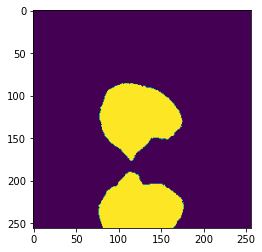

Epoch 1
1.0 (1, 256, 256, 1)


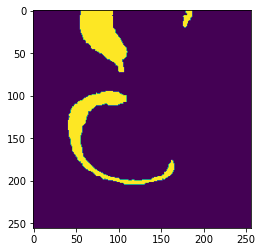

Epoch 2
1.0 (1, 256, 256, 1)


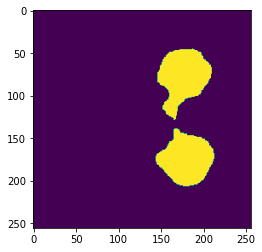

Epoch 3
1.0 (1, 256, 256, 1)


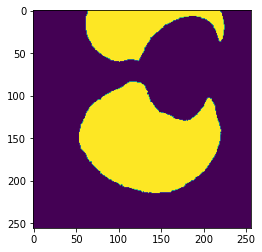

Epoch 4
1.0 (1, 256, 256, 1)


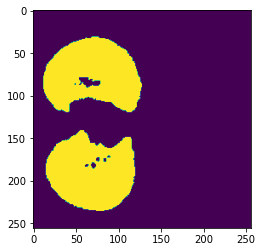

In [27]:
# for e in range(5):
#     print('Epoch', e)
#     batches = 0
#     for x_batch, y_batch in data_gen:
#         print(np.max(y_batch), np.shape(y_batch))
#         plt.imshow(np.squeeze(y_batch))
        

#         plt.show()
        
#         break

In [29]:
#Step 2: Initialize the model. Train from scratch!
# Initialize model like you usually do.
#tf.keras.backend.clear_session()
#mod.compile(optimizer = Adam(learning_rate=0.0001), loss = bce_dice_loss, metrics = dice_coef)
#mod.compile(optimizer = Adam(learning_rate=0.0001), loss = "binary_crossentropy", metrics = "acc")
mod.compile(optimizer = Adam(learning_rate=0.0001), loss = dice_coef_loss, metrics = dice_coef)

In [30]:
# Notice WandbCallback is used as a regular callback
# We again use config
hist = mod.fit(data_gen,steps_per_epoch=25,epochs=50,verbose=1)
          #        mod.fit(x_train, y_train,
          # epochs=50, 
          # batch_size=5, verbose=1)

Found 829 images belonging to 1 classes.
Found 829 images belonging to 1 classes.
Epoch 1/50
25/25 [==============================] - 12s 88ms/step - loss: -1.6474 - output_1_loss: -0.3724 - output_2_loss: -0.4301 - output_3_loss: -0.3969 - output_4_loss: -0.4480 - output_1_dice_coef: 0.3724 - output_2_dice_coef: 0.4301 - output_3_dice_coef: 0.3969 - output_4_dice_coef: 0.4480
Epoch 2/50
25/25 [==============================] - 2s 87ms/step - loss: -2.2599 - output_1_loss: -0.4699 - output_2_loss: -0.5365 - output_3_loss: -0.6105 - output_4_loss: -0.6431 - output_1_dice_coef: 0.4699 - output_2_dice_coef: 0.5365 - output_3_dice_coef: 0.6105 - output_4_dice_coef: 0.6431
Epoch 3/50
25/25 [==============================] - 2s 88ms/step - loss: -3.0459 - output_1_loss: -0.5546 - output_2_loss: -0.7682 - output_3_loss: -0.8636 - output_4_loss: -0.8594 - output_1_dice_coef: 0.5546 - output_2_dice_coef: 0.7682 - output_3_dice_coef: 0.8636 - output_4_dice_coef: 0.8594
Epoch 4/50
25/25 [========

25/25 [==============================] - 2s 88ms/step - loss: -3.3479 - output_1_loss: -0.7350 - output_2_loss: -0.8323 - output_3_loss: -0.8801 - output_4_loss: -0.9005 - output_1_dice_coef: 0.7350 - output_2_dice_coef: 0.8323 - output_3_dice_coef: 0.8801 - output_4_dice_coef: 0.9005
Epoch 29/50
25/25 [==============================] - 2s 89ms/step - loss: -3.6351 - output_1_loss: -0.8245 - output_2_loss: -0.9062 - output_3_loss: -0.9491 - output_4_loss: -0.9553 - output_1_dice_coef: 0.8245 - output_2_dice_coef: 0.9062 - output_3_dice_coef: 0.9491 - output_4_dice_coef: 0.9553
Epoch 30/50
25/25 [==============================] - 2s 89ms/step - loss: -3.6766 - output_1_loss: -0.8361 - output_2_loss: -0.9192 - output_3_loss: -0.9568 - output_4_loss: -0.9645 - output_1_dice_coef: 0.8361 - output_2_dice_coef: 0.9192 - output_3_dice_coef: 0.9568 - output_4_dice_coef: 0.9645
Epoch 31/50
25/25 [==============================] - 2s 89ms/step - loss: -3.5431 - output_1_loss: -0.8074 - output_2_

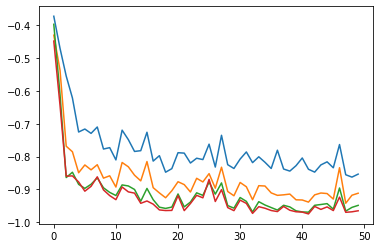

In [31]:
plt.plot(hist.history['output_1_loss'])
plt.plot(hist.history['output_2_loss'])
plt.plot(hist.history['output_3_loss'])
plt.plot(hist.history['output_4_loss'])

# Generate results!

In [32]:
#Step 1: Run model on test images and save the images
#number of test images
n_i=len(os.listdir(PATH+'Images\\'))
#Call test generator
test_gen= testGenerator(PATH+'Images\\')


In [33]:
#Return model outcome for each test image
results = mod.predict_generator(test_gen,n_i,verbose=1)

C:\Users\Sohini Roy\anaconda3\envs\flow\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


image0.jpg
image1.jpg
  1/829 [..............................] - ETA: 4:57image10.jpg
image100.jpg
image101.jpg
image102.jpg
image103.jpg
  6/829 [..............................] - ETA: 10s image104.jpg
image105.jpg
image106.jpg
image107.jpg
 10/829 [..............................] - ETA: 11simage108.jpg
image109.jpg
image11.jpg
image110.jpg
 14/829 [..............................] - ETA: 11simage111.jpg
image112.jpg
image113.jpg
image114.jp
 18/829 [..............................] - ETA: 11simage115.jpg
image116.jpg
image117.jpg
image118.jp
 22/829 [..............................] - ETA: 11simage119.jpg
image12.jpg
image120.jpg
image121.jpg
 26/829 [..............................] - ETA: 11simage122.jpg
image123.jpg
image124.jpg
image125.jp
 30/829 [>.............................] - ETA: 11simage126.jpg
image127.jpg
image128.jpg
image129.jpg
image13.jpg
 35/829 [>.............................] - ETA: 11simage130.jpg
image131.jpg
image132.jpg
image133.jpg
 39/829 [>....................

image399.jpg
333/829 [===========>..................] - ETA: 7simage4.jpg
image40.jpg
image400.jpg
337/829 [===========>..................] - ETA: 7simage401.jpg
image402.jpg
image403.jpg
image404.jpg
340/829 [===========>..................] - ETA: 7simage405.jpg
image406.jpg
image407.jpg
image408.j
344/829 [===========>..................] - ETA: 7simage409.jpg
image41.jpg
image410.jpg
image411.jpg
348/829 [===========>..................] - ETA: 7simage412.jpg
image413.jpg
image414.jpg
image415.j
352/829 [===========>..................] - ETA: 7simage416.jpg
image417.jpg
image418.jpg
image419.jpg
356/829 [===========>..................] - ETA: 6simage42.jpg
image420.jpg
image421.jpg
image422.jpg
360/829 [============>.................] - ETA: 6simage423.jpg
image424.jpg
image425.jpg
image426.jpg
image427.jpg
365/829 [============>.................] - ETA: 6simage428.jpg
image429.jpg
image43.jpg
image430.jpg
image431.j
370/829 [============>.................] - ETA: 6simage432.jpg
image

664/829 [=======================>......] - ETA: 2simage697.jpg
image698.jpg
image699.jpg
image7.jpg
668/829 [=======================>......] - ETA: 2s
image700.jpg
image701.jpg
image702.jpg
image703.j
672/829 [=======================>......] - ETA: 2simage704.jpg
image705.jpg
image706.jpg
image707.j
676/829 [=======================>......] - ETA: 2simage708.jpg
image709.jpg
image71.jpg
image710.j
680/829 [=======================>......] - ETA: 2simage711.jpg
image712.jpg
image713.jpg
image714.jpg
684/829 [=======================>......] - ETA: 2simage715.jpg
image716.jpg
image717.jpg
image718.j
688/829 [=======================>......] - ETA: 2simage719.jpg
image72.jpg
image720.jpg
692/829 [========================>.....] - ETA: 2s
image722.jpg
image723.jpg
image724.jpg
696/829 [========================>.....] - ETA: 1s
image726.jpg
image727.jpg
image728.jpg
image729.j
700/829 [========================>.....] - ETA: 1simage73.jpg
image730.jpg
image731.jpg
image732.j
704/829 [===========

In [ ]:
#Lets save the STARE predictions
SaveResultwImage('./cirrus_2/test/Image/','./cirrus_2/test/pred/',results[3])

In [34]:
np.shape(results)

(4, 829, 256, 256, 1)

In [ ]:
#Lets visualize the STARE predictions
plt.imshow(results[3][5][:,:,0])

In [39]:
PATH+'GT\\'

'.\\covid-19-rad\\GT\\'

In [47]:
# Results of nested Level 1
evalResult(PATH+'GT\\',results[0])

C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered

C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered

C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)


Precision= 0.7738375533475964 Recall= nan IoU= 0.6418131983926912 acc= 0.9654013860355096 F1= 0.7034368559374465


In [48]:
evalResult(PATH+'GT\\',results[1])

C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered

C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered

C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)


Precision= 0.8143899127232376 Recall= nan IoU= 0.7056057401973842 acc= 0.9774632839299514 F1= 0.7522557719797183


In [49]:
evalResult(PATH+'GT\\',results[2])

C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered

C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered

C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)


Precision= 0.824351928989831 Recall= nan IoU= 0.732100358358963 acc= 0.9815449639885215 F1= 0.7706495038770936


In [ ]:
evalResult(PATH+'GT\\',results[3])

C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered in double_scalars
  rec=tp/(tp+fn)
C:\Users\SOHINI~1\AppData\Local\Temp/ipykernel_12732/1562306391.py:21: RuntimeWarning: invalid value encountered